In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from detectors import detectors_dir
from models import models_dir


In [4]:
import cmasher as cmr
cmap_pd = cmr.get_sub_cmap('brg', 0.5, 1)
cmap_auc = cmr.get_sub_cmap('brg', 0, 1)

## Setup


In [5]:
anomalies_labels = [
    'GWN', 
    'Impulse', 
    'Step', 
    'Constant',  
    'GNN',
    'MixingGWN', 
    'MixingConstant',
    'SpectralAlteration', 
    'PrincipalSubspaceAlteration',
    'TimeWarping',
    'Clipping',
    'Dead-Zone'
]

feature_detectors = ['MD', 'TV', 'ZC', 'pk-pk', 'energy']

results_folder = '/srv/newpenny/dnn-cs/tsoc/results/TSOC/detection'

# Detector-specific configuration
kernel = "rbf"       
nu_list = [0.001, 0.01, 0.1]
neighbors_list = [5, 10, 20, 50]
estimators_list = [5, 10, 20, 50, 100, 200, 500, 1000]

k_list = [1, 2, 4, 8, 16, 24, 32, 46]
order_list = [1, 2, 4, 8, 16, 24]

seed_train_list = [0, 1, 2, 3, 4]
opt_list = ['adam', 'sgd']
bs_list = [32, 64, 128]
min_delta_list = [1e-4, 1e-5]

# Anomalies configuration
seed_ko = 0
N_test = 10_000
delta_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

m_list = [32, 48, 64]
mode_list = ['standard', 'rakeness']
ort_list = [True, False]
seed_mat_list = []

# Fixed parameters
m = 48
mode = 'rakeness'
orthogonal = True
seed_mat = 30808
seed_train = 0
opt = 'adam'
min_delta = 1e-5

In [6]:
## plot P_D vs delta for different detector's parameters
def plot_performance(data, parameters, parameter_label):
    handles = []
    labels = []
    fig, ax = plt.subplots(2, len(anomalies_labels), figsize=(21, 5), sharey=True, sharex=True)
    for parameter in parameters:
        for j, anomaly in enumerate(anomalies_labels):
            data_ = data.xs(key=parameter, level=parameter_label)[anomaly]
            ax[0, j].set(title=anomaly)
            # ax[0, j].plot(data_.index, 1- data_, label=f'{parameter_label}={parameter}')
            ax[0, j].plot(data_.index, 1- data_)
            # ax[1, j].plot(data_.index, 0.5 + abs(data_.values-0.5), label=f'{parameter_label}={parameter}')
            handle, = ax[1, j].plot(data_.index, 0.5 + abs(data_.values-0.5))
            ax[1, j].set(xlabel='$\delta$')
            if j == 0:
                handles.append(handle)
                labels.append(f'{parameter_label}={parameter}')
    ax[0, 0].set(ylabel='1-AUC')
    ax[1, 0].set(ylabel='$P_D$')

    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        ncol=len(parameters),
        fontsize=9,
        bbox_to_anchor=(0.5, 1.0),  # Adjust position relative to the figure
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])


In [7]:
# identify all trained detecors
trained_detectors = os.listdir(detectors_dir)
trained_detectors = [trained_detector for trained_detector in trained_detectors if not 'seedselect' in trained_detector]

In [8]:
# parameters of the detector from its name
def parse_detector_parameters(detector_name):
    detector_name = detector_name.split('.pkl')[0]
    params = detector_name.split('_')
    param_dict = {}
    param_dict['detector'] = params[0]
    for param in params[1:]:
        key, value = param.split('=')
        # Attempt to convert to int, float, or keep as string
        if value.isdigit():
            param_dict[key] = int(value)
        else:
            try:
                param_dict[key] = float(value)
            except ValueError:
                # Special case for booleans
                if value.lower() in ['true', 'false']:
                    param_dict[key] = value.lower() == 'true'
                else:
                    param_dict[key] = value

    return param_dict

In [9]:
def load_results(detector_label, parameter_label):
    index = pd.MultiIndex.from_product(
    [delta_list, m_list, mode_list, ort_list, seed_mat_list, estimators_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', parameter_label])

    results = pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
    for delta in delta_list:
        for trained_detector in trained_detectors:
            params = parse_detector_parameters(trained_detector)
            if not params['detector'] == detector_label:
                continue
            if not params['seedmat'] == seed_mat:
                continue
            trained_detector = f"{trained_detector.split('.pkl')[0]}"
            results_path = os.path.join(results_folder, f'AUC_detector={trained_detector}_delta={delta}_seedko={seed_ko}.pkl')
            if os.path.exists(results_path):
                result_ = pd.read_pickle(results_path)
                results.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params[parameter_label]] = result_
    # results['mean'] = results.mean(axis=-1)
    return results


## Isolation Forest

In [10]:
detector_label = 'IF'
parameter_label = 'estimators'
results_IF = load_results(detector_label, parameter_label)

In [11]:
(1-results_IF).style.background_gradient(cmap=cmap_auc, vmin=0.5, vmax=1)

In [12]:
results_IF_PD = 0.5 + np.abs(results_IF-0.5)
results_IF_PD['mean'] = results_IF_PD.mean(axis=1)
results_IF_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [96]:
results_IF_avg = results_IF_PD.groupby('estimators').mean()
estimators = results_IF_avg['mean'].idxmax()
print(f'Best # estimators = {estimators}')
results_IF_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best # estimators = 1000


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
estimators,,,,,,,,,,,,,
5,0.583395,0.556598,0.547118,0.525344,0.579566,0.541673,0.526592,0.531158,0.512036,0.502815,0.637324,0.536401,0.548335
10,0.592003,0.552423,0.554137,0.526216,0.589126,0.541850,0.533741,0.541088,0.526324,0.505839,0.661326,0.538902,0.555248
20,0.593047,0.553204,0.545824,0.522242,0.590407,0.538366,0.541969,0.544678,0.535049,0.506370,0.671163,0.541477,0.556983
50,0.606641,0.574655,0.557690,0.537040,0.602476,0.539470,0.546930,0.540227,0.548557,0.504832,0.695501,0.557688,0.567642
100,0.620914,0.587186,0.570222,0.545974,0.617825,0.547070,0.553017,0.553910,0.560785,0.504573,0.711623,0.559295,0.577700
200,0.623762,0.592270,0.576042,0.550401,0.619810,0.546296,0.551553,0.551352,0.565490,0.504535,0.712893,0.559390,0.579483
500,0.626554,0.595491,0.574697,0.550686,0.622452,0.547347,0.555348,0.551213,0.568180,0.505297,0.714276,0.560675,0.581018
1000,0.625783,0.593734,0.574120,0.548282,0.621700,0.545196,0.558014,0.552409,0.573045,0.504492,0.715579,0.561368,0.581144


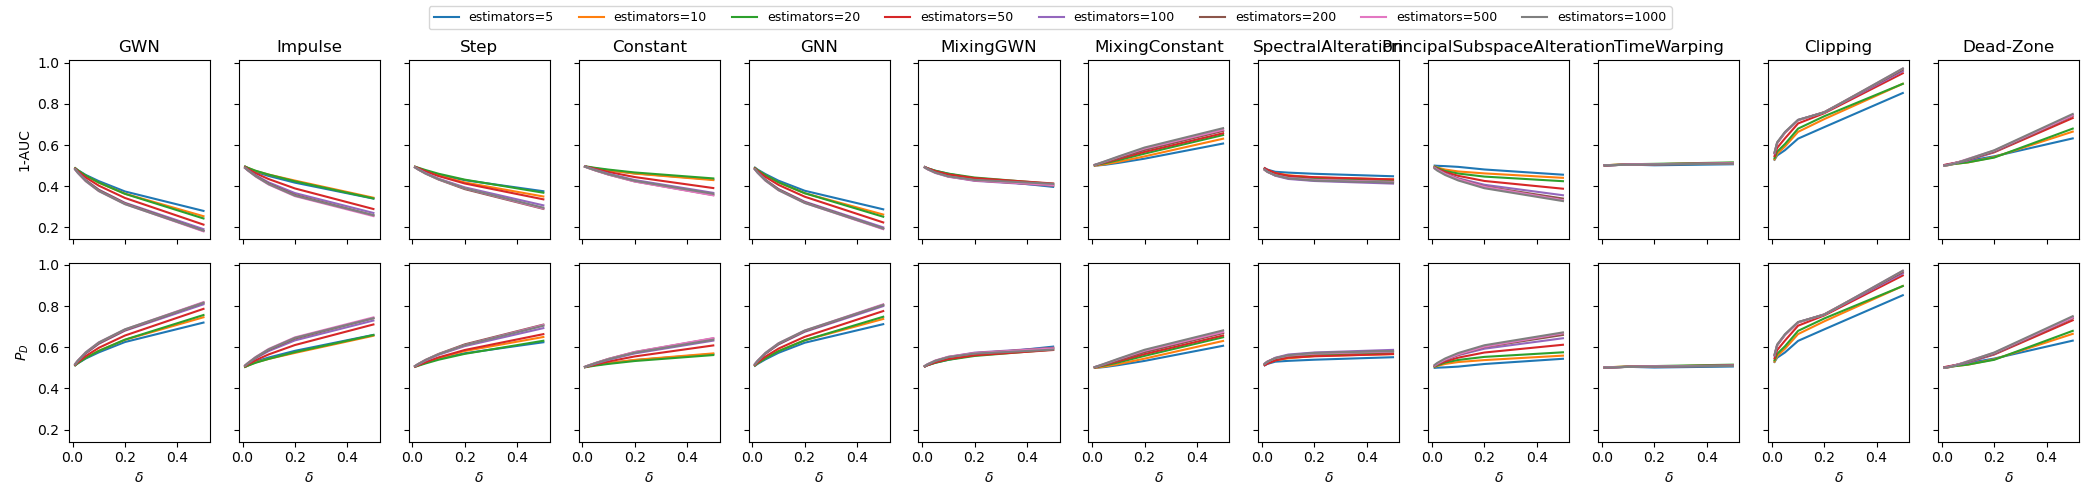

In [13]:
data_IF = results_IF.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_IF, estimators_list, 'estimators')

## LOF

In [14]:
detector_label = 'LOF'
parameter_label = 'neighbors'
results_LOF = load_results(detector_label, parameter_label)

In [15]:
(1-results_LOF).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [16]:
results_LOF_PD = 0.5 + np.abs(results_LOF-0.5)
results_LOF_PD['mean'] = results_LOF_PD.mean(axis=1)
results_LOF_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [97]:
results_LOF_avg = results_LOF_PD.groupby('neighbors').mean()
neighbors = results_LOF_avg['mean'].idxmax()
print(f'Best # neighbors = {neighbors}')
results_LOF_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best # neighbors = 10


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
neighbors,,,,,,,,,,,,,
5,0.999763,0.999698,0.998187,0.951211,0.999098,0.999784,0.878841,0.997863,0.999774,0.588209,0.933176,0.998373,0.945331
10,0.999655,0.999534,0.997807,0.957570,0.998970,0.999668,0.898817,0.997767,0.999719,0.585277,0.933399,0.998246,0.947202
20,0.999522,0.999303,0.997136,0.957603,0.998732,0.999536,0.904777,0.997201,0.999655,0.575405,0.931928,0.997950,0.946562
50,0.998893,0.998330,0.994863,0.951998,0.997807,0.998888,0.896721,0.995207,0.999180,0.557532,0.927796,0.997212,0.942869


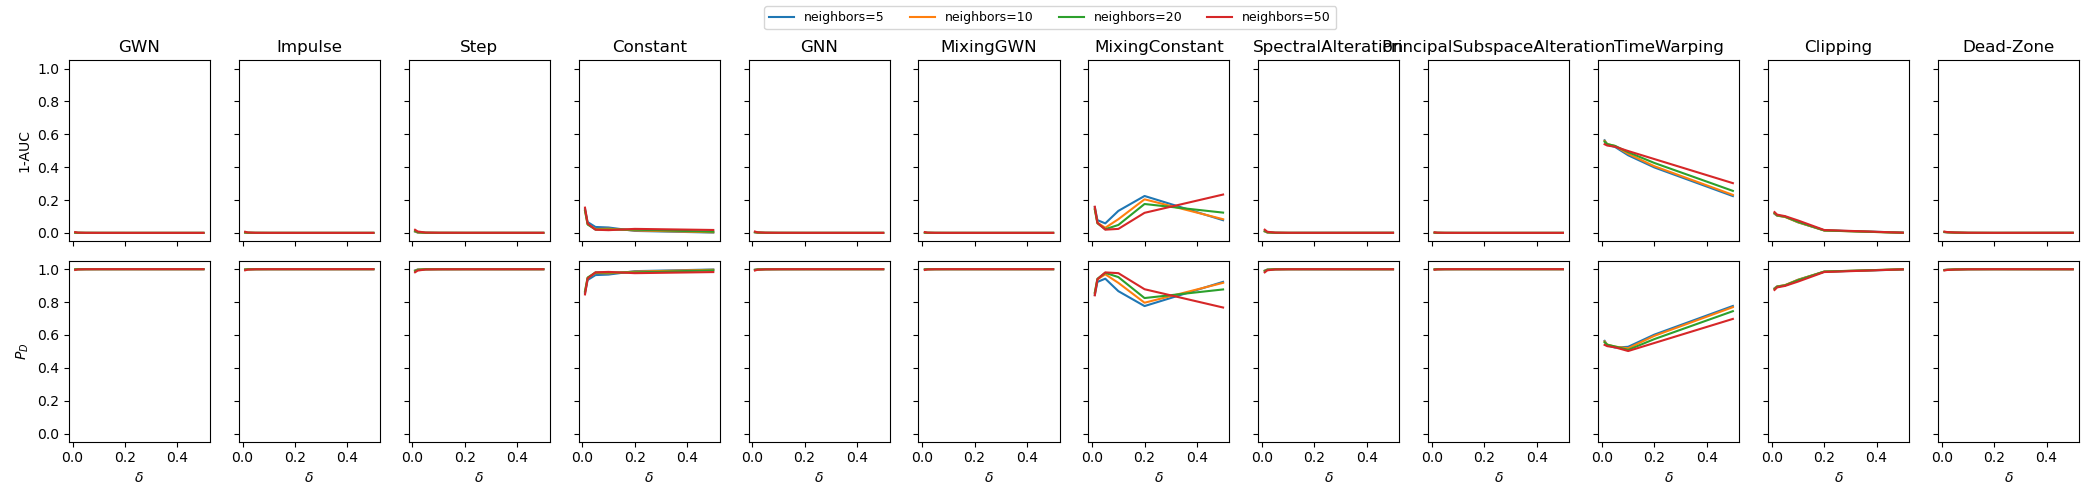

In [17]:
data_LOF = results_LOF.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_LOF, neighbors_list, 'neighbors')

## OCSVM

In [18]:
detector_label = 'OCSVM'
parameter_label = 'nu'
results_OCSVM = load_results(detector_label, parameter_label)

In [19]:
(1-results_OCSVM).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [49]:
# (0.5 + np.abs(results_OCSVM-0.5)).style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)
results_OCSVM_PD = 0.5 + np.abs(results_OCSVM-0.5)
results_OCSVM_PD['mean'] = results_OCSVM_PD.mean(axis=1)
results_OCSVM_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [92]:
results_OCSVM_avg = results_OCSVM_PD.groupby('nu').mean()
nu = results_OCSVM_avg['mean'].idxmax()
print(f'Best nu = {nu}')
results_OCSVM_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best nu = 0.01


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
nu,,,,,,,,,,,,,
0.001000,0.686335,0.657571,0.605905,0.585266,0.680029,0.593334,0.597388,0.576195,0.614015,0.508955,0.780273,0.586748,0.622668
0.010000,0.691498,0.662814,0.622779,0.600697,0.685472,0.596019,0.594558,0.576308,0.618030,0.507937,0.780343,0.589308,0.627147
0.100000,0.690693,0.661932,0.623965,0.600408,0.684753,0.594791,0.588656,0.574831,0.616795,0.506332,0.780516,0.586929,0.625883


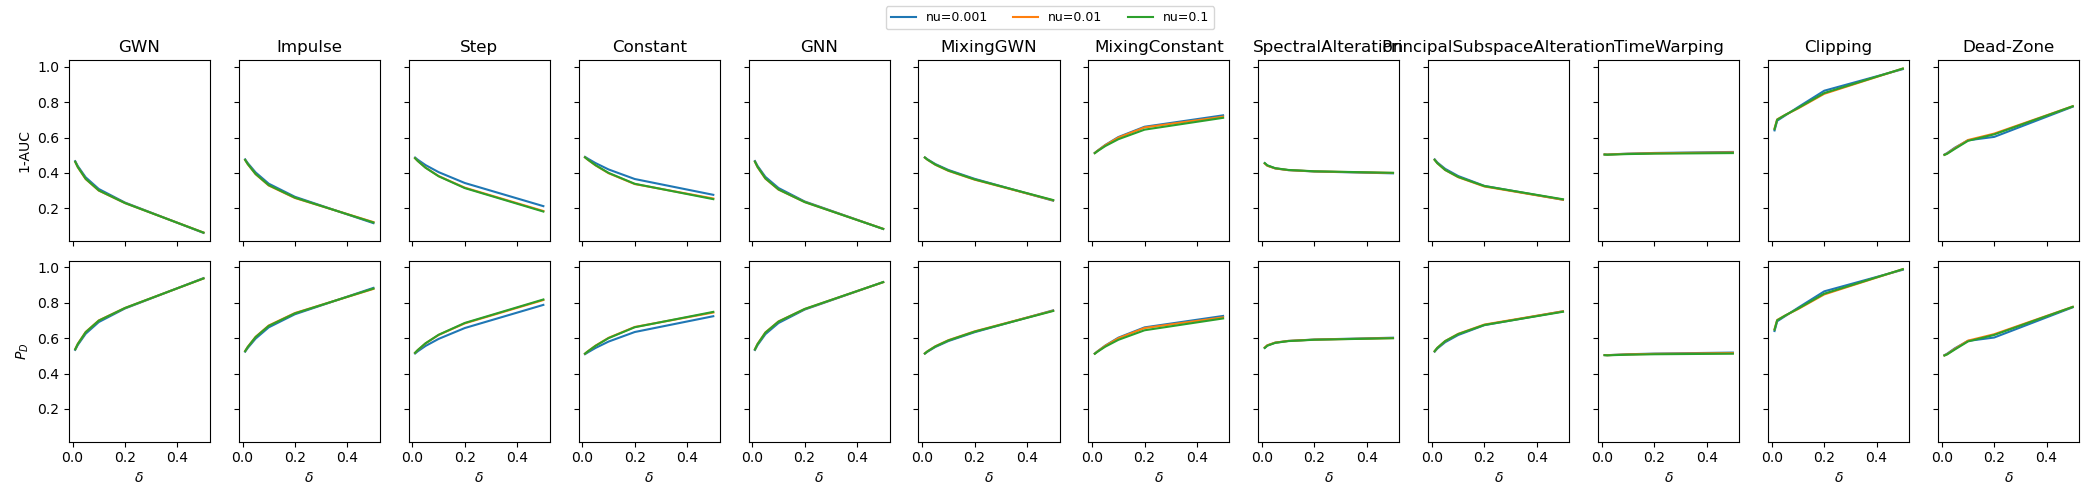

In [21]:
data_OCSVM = results_OCSVM.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_OCSVM, nu_list, 'nu')

## SPE

In [62]:
detector_label = 'SPE'
parameter_label = 'k'
results_SPE = load_results(detector_label, parameter_label)

In [63]:
(1-results_SPE).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [65]:
results_SPE_PD = 0.5 + np.abs(results_SPE-0.5)
results_SPE_PD['mean'] = results_SPE_PD.mean(axis=1)
results_SPE_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [98]:
results_SPE_avg = results_SPE_PD.groupby('k').mean()
k = results_SPE_avg['mean'].idxmax()
print(f'Best k = {k}')
results_SPE_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best k = 32


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
k,,,,,,,,,,,,,
1,0.561683,0.555067,0.560503,0.502117,0.560854,0.566615,0.610339,0.511919,0.566848,0.509546,0.733074,0.625122,0.571974
2,0.562241,0.556206,0.559792,0.502528,0.561450,0.558855,0.606666,0.520967,0.558882,0.503761,0.730370,0.607609,0.569111
4,0.570542,0.560876,0.548043,0.502388,0.568581,0.542814,0.598966,0.562299,0.543938,0.501914,0.719064,0.572711,0.566011
8,0.580830,0.564613,0.537975,0.501986,0.578843,0.506266,0.580507,0.580618,0.502682,0.507963,0.713444,0.573790,0.560793
16,0.730620,0.703801,0.517082,0.500321,0.710551,0.717386,0.544886,0.547060,0.695448,0.531207,0.684497,0.584060,0.622243
24,0.990494,0.989856,0.645832,0.500223,0.925089,0.990462,0.539737,0.504547,0.979998,0.552053,0.626059,0.924911,0.764105
32,1.000000,1.000000,0.828713,0.500037,0.922617,1.000000,0.595316,0.500376,0.999994,0.627706,0.795337,0.999001,0.814091
46,0.988858,1.000000,0.775463,0.500014,0.879083,0.989069,0.540188,0.500130,0.994143,0.582008,0.718957,0.942833,0.784229


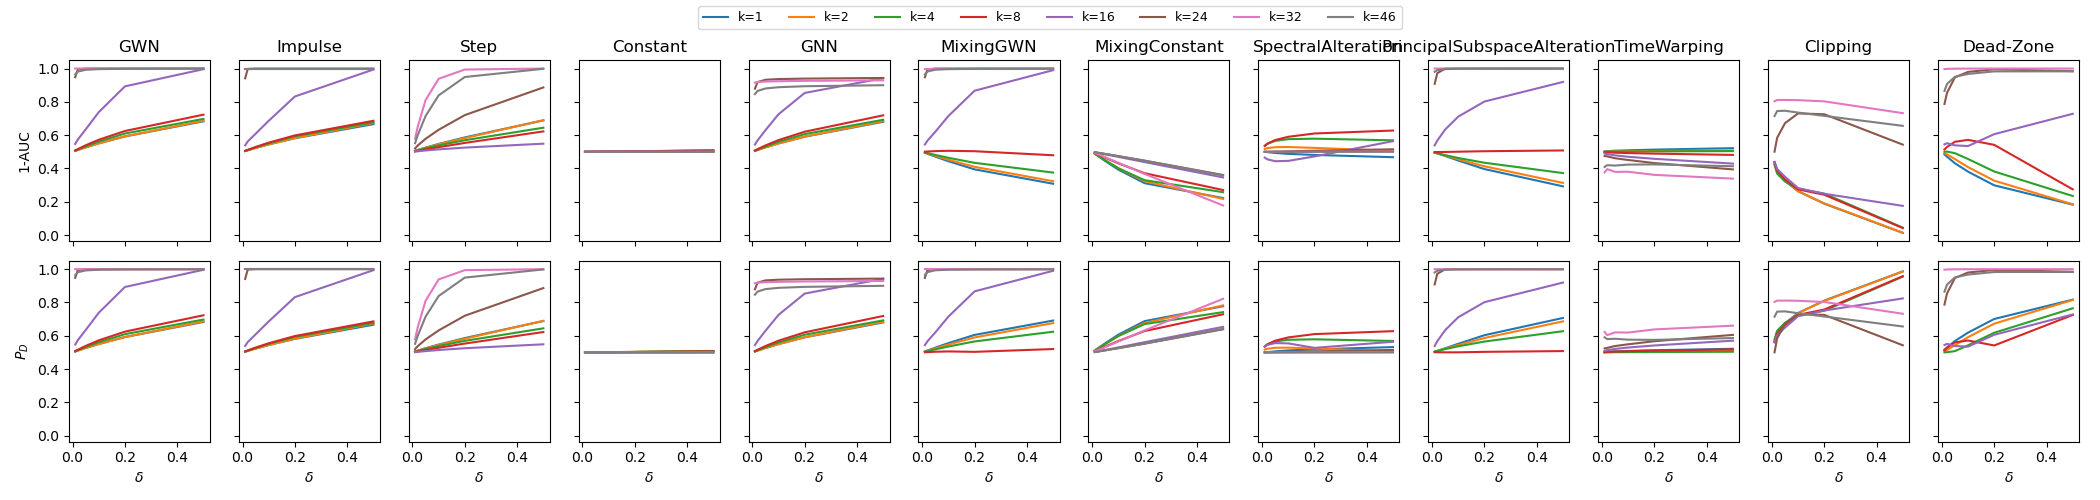

In [25]:
data_SPE = results_SPE.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_SPE, k_list, 'k')

## T2

In [26]:
detector_label = 'T2'
parameter_label = 'k'
results_T2 = load_results(detector_label, parameter_label)

In [68]:
(1-results_T2).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [69]:
results_T2_PD = 0.5 + np.abs(results_T2-0.5)
results_T2_PD['mean'] = results_T2_PD.mean(axis=1)
results_T2_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [99]:
results_T2_avg = results_T2_PD.groupby('k').mean()
k = results_T2_avg['mean'].idxmax()
print(f'Best k = {k}')
results_T2_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best k = 46


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
k,,,,,,,,,,,,,
1,0.500528,0.500192,0.505479,0.518071,0.500270,0.501202,0.510685,0.504195,0.502035,0.503101,0.563411,0.587700,0.516406
2,0.502992,0.502790,0.521809,0.544542,0.502904,0.521441,0.520765,0.579144,0.526606,0.500690,0.602400,0.515035,0.528427
4,0.505763,0.512235,0.536842,0.542201,0.505573,0.556471,0.508199,0.651962,0.556061,0.509145,0.604361,0.608720,0.549795
8,0.510324,0.521346,0.548028,0.529918,0.509543,0.573420,0.545847,0.595690,0.568116,0.506742,0.677903,0.643609,0.560874
16,0.527195,0.528162,0.562873,0.523109,0.523591,0.593727,0.587770,0.560037,0.598234,0.507846,0.733054,0.594190,0.569982
24,0.629079,0.551214,0.547751,0.516883,0.619822,0.553087,0.589692,0.587217,0.545491,0.533310,0.763120,0.532487,0.580763
32,0.929901,0.974651,0.604913,0.510113,0.880370,0.928062,0.570667,0.563161,0.900158,0.543438,0.618718,0.794473,0.734886
46,0.999995,0.999984,0.731496,0.507470,0.936454,0.999997,0.580946,0.558862,0.999572,0.571467,0.731817,0.995107,0.801097


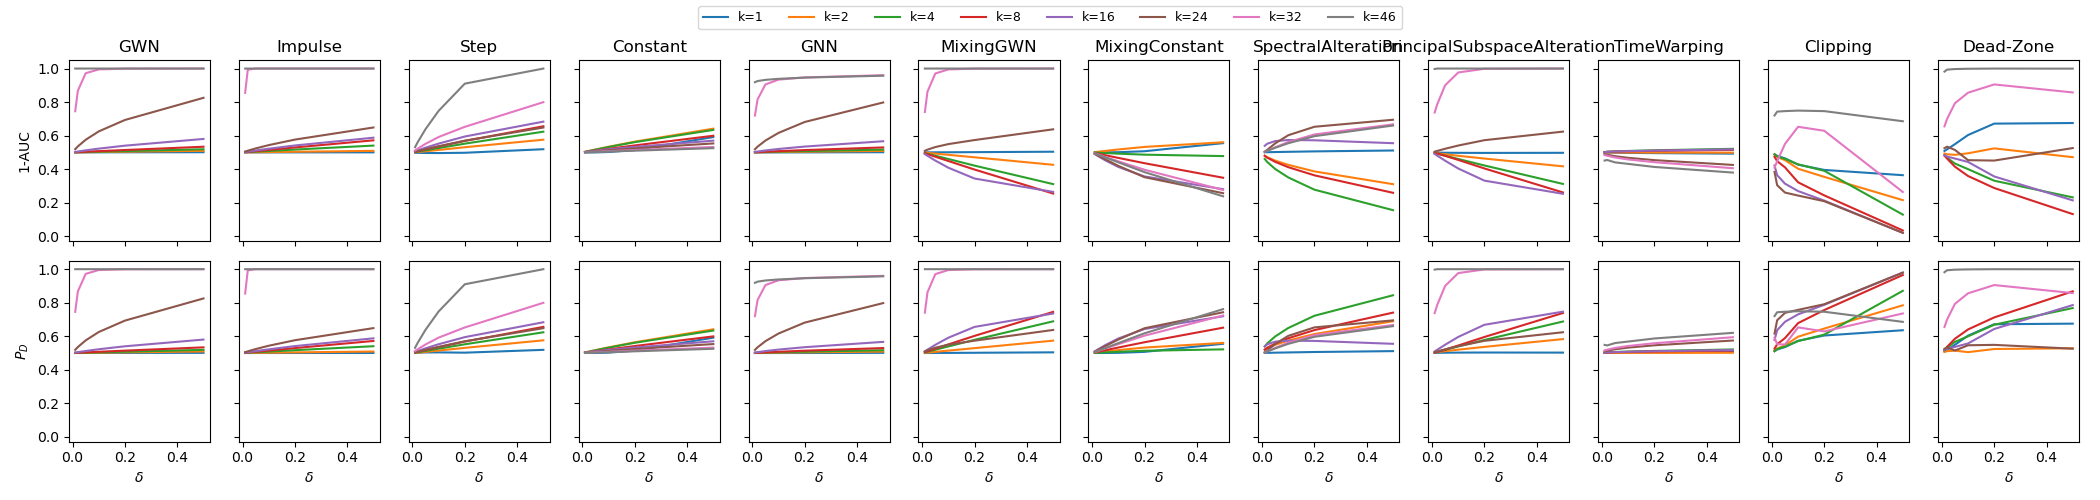

In [29]:
data_T2 = results_T2.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_T2, k_list, 'k')

## AR

In [71]:
detector_label = 'AR'
parameter_label = 'order'
results_AR = load_results(detector_label, parameter_label)

In [72]:
(1-results_AR).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [73]:
results_AR_PD = 0.5 + np.abs(results_AR-0.5)
results_AR_PD['mean'] = results_AR_PD.mean(axis=1)
results_AR_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [101]:
results_AR_avg = results_AR_PD.groupby('order').mean()
order = results_AR_avg['mean'].idxmax()
print(f'Best roder = {order}')
results_AR_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best roder = 1


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
order,,,,,,,,,,,,,
1,0.556403,0.550912,0.557062,0.514166,0.556011,0.557059,0.586342,0.514064,0.556632,0.506859,0.727489,0.613440,0.566370
2,0.552763,0.547345,0.550323,0.511981,0.552599,0.548200,0.580210,0.509019,0.544867,0.501858,0.717876,0.595948,0.559416
4,0.556437,0.554051,0.549099,0.513210,0.556823,0.539403,0.577954,0.519592,0.529066,0.500624,0.722094,0.580066,0.558202
8,0.560613,0.538737,0.547195,0.509117,0.560004,0.506114,0.560803,0.541693,0.505932,0.505122,0.703239,0.557072,0.549637
16,0.583922,0.553665,0.527891,0.508354,0.581765,0.527484,0.556438,0.545669,0.536554,0.506007,0.692344,0.542568,0.555222
24,0.609734,0.576832,0.530638,0.509482,0.605196,0.559670,0.556097,0.533494,0.554120,0.506658,0.695719,0.536151,0.564483
32,0.613173,0.561260,0.527664,0.507944,0.608589,0.567036,0.555661,0.542670,0.547757,0.504554,0.684894,0.542465,0.563639
46,0.565163,0.540659,0.537756,0.504055,0.562079,0.543753,0.532257,0.528896,0.550956,0.503105,0.604652,0.528444,0.541815


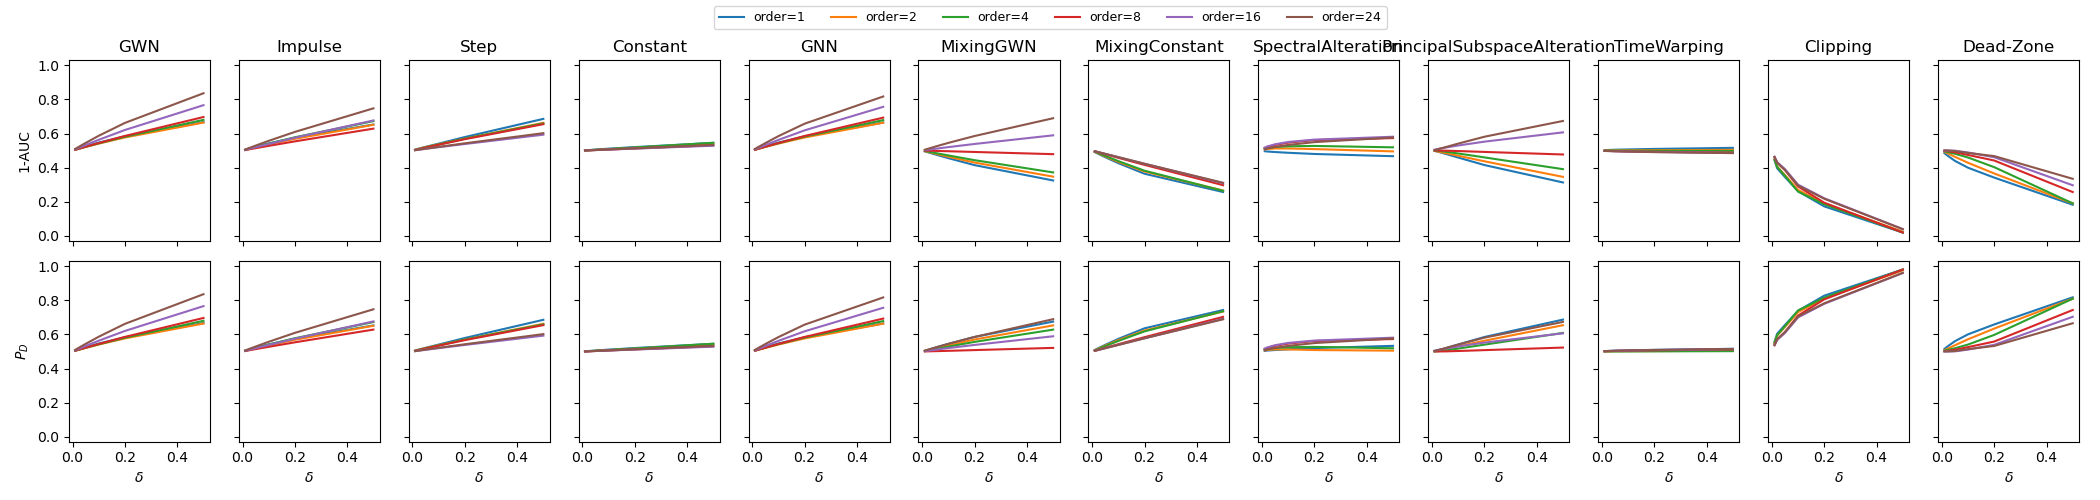

In [74]:
data_AR = results_AR.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_AR, order_list, 'order')

## Feature-based

In [76]:
results_FB = []
for detector_label in feature_detectors:
  result = load_results(detector_label, 'detector')
  results_FB.append(result)
results_FB = pd.concat(results_FB)

In [77]:
(1-results_FB).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

,,,,,,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone
delta,m,mode,ort,seedmat,detector,,,,,,,,,,,,
0.010000,48,rakeness,True,30808,MD,0.999996,1.000000,0.536984,0.500483,0.918701,1.000000,0.493902,0.503914,0.998308,0.443330,0.727334,0.987154
0.020000,48,rakeness,True,30808,MD,1.000000,1.000000,0.571613,0.500983,0.925363,1.000000,0.487812,0.509727,0.999965,0.447128,0.745296,0.995332
0.050000,48,rakeness,True,30808,MD,1.000000,1.000000,0.662632,0.502478,0.932544,1.000000,0.469410,0.527551,1.000000,0.432840,0.747852,0.997450
0.100000,48,rakeness,True,30808,MD,1.000000,1.000000,0.788795,0.504984,0.938535,1.000000,0.438636,0.554723,1.000000,0.424454,0.750010,0.998894
0.200000,48,rakeness,True,30808,MD,1.000000,1.000000,0.947707,0.509978,0.945795,1.000000,0.378106,0.596839,1.000000,0.406284,0.746385,0.999920
0.500000,48,rakeness,True,30808,MD,1.000000,1.000000,0.999991,0.524687,0.957220,1.000000,0.230047,0.660426,1.000000,0.371887,0.692614,0.999729
0.010000,48,rakeness,True,30808,TV,0.504702,0.503592,0.502866,0.501248,0.504876,0.499074,0.496050,0.509063,0.500149,0.499596,0.461246,0.497446
0.020000,48,rakeness,True,30808,TV,0.509293,0.507353,0.505791,0.502561,0.509512,0.498154,0.492149,0.512717,0.500012,0.499954,0.427099,0.495465
0.050000,48,rakeness,True,30808,TV,0.522607,0.518731,0.514637,0.506573,0.522868,0.495290,0.480639,0.518420,0.499080,0.499940,0.383528,0.486860


In [78]:
results_FB_PD = 0.5 + np.abs(results_FB-0.5)
results_FB_PD['mean'] = results_FB_PD.mean(axis=1)
results_FB_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

,,,,,,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
delta,m,mode,ort,seedmat,detector,,,,,,,,,,,,,
0.010000,48,rakeness,True,30808,MD,0.999996,1.000000,0.536984,0.500483,0.918701,1.000000,0.506098,0.503914,0.998308,0.556670,0.727334,0.987154,0.769637
0.020000,48,rakeness,True,30808,MD,1.000000,1.000000,0.571613,0.500983,0.925363,1.000000,0.512188,0.509727,0.999965,0.552872,0.745296,0.995332,0.776112
0.050000,48,rakeness,True,30808,MD,1.000000,1.000000,0.662632,0.502478,0.932544,1.000000,0.530590,0.527551,1.000000,0.567160,0.747852,0.997450,0.789021
0.100000,48,rakeness,True,30808,MD,1.000000,1.000000,0.788795,0.504984,0.938535,1.000000,0.561364,0.554723,1.000000,0.575546,0.750010,0.998894,0.806071
0.200000,48,rakeness,True,30808,MD,1.000000,1.000000,0.947707,0.509978,0.945795,1.000000,0.621894,0.596839,1.000000,0.593716,0.746385,0.999920,0.830186
0.500000,48,rakeness,True,30808,MD,1.000000,1.000000,0.999991,0.524687,0.957220,1.000000,0.769953,0.660426,1.000000,0.628113,0.692614,0.999729,0.852728
0.010000,48,rakeness,True,30808,TV,0.504702,0.503592,0.502866,0.501248,0.504876,0.500926,0.503950,0.509063,0.500149,0.500404,0.538754,0.502554,0.506090
0.020000,48,rakeness,True,30808,TV,0.509293,0.507353,0.505791,0.502561,0.509512,0.501846,0.507851,0.512717,0.500012,0.500046,0.572901,0.504535,0.511202
0.050000,48,rakeness,True,30808,TV,0.522607,0.518731,0.514637,0.506573,0.522868,0.504710,0.519361,0.518420,0.500920,0.500060,0.616472,0.513140,0.521542


In [102]:
results_FB_avg = results_FB_PD.groupby('detector').mean()
detector = results_FB_avg['mean'].idxmax()
print(f'Best detector = {detector}')
results_FB_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best detector = MD


,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
detector,,,,,,,,,,,,,
MD,0.999999,1.000000,0.751287,0.507265,0.936360,1.000000,0.583681,0.558864,0.999712,0.579013,0.734915,0.996413,0.803959
TV,0.556938,0.550954,0.541894,0.520895,0.556487,0.516320,0.548922,0.519662,0.511090,0.500533,0.694496,0.560214,0.548200
ZC,0.514519,0.527564,0.506642,0.510063,0.517297,0.517418,0.517061,0.522840,0.524375,0.505390,0.507746,0.531726,0.516887
energy,0.535556,0.532958,0.546936,0.533906,0.535692,0.535960,0.509292,0.516171,0.535489,0.502413,0.685224,0.550122,0.543310
pk-pk,0.508260,0.513445,0.552409,0.559661,0.508555,0.528278,0.526771,0.520509,0.530908,0.500651,0.634155,0.529823,0.534452


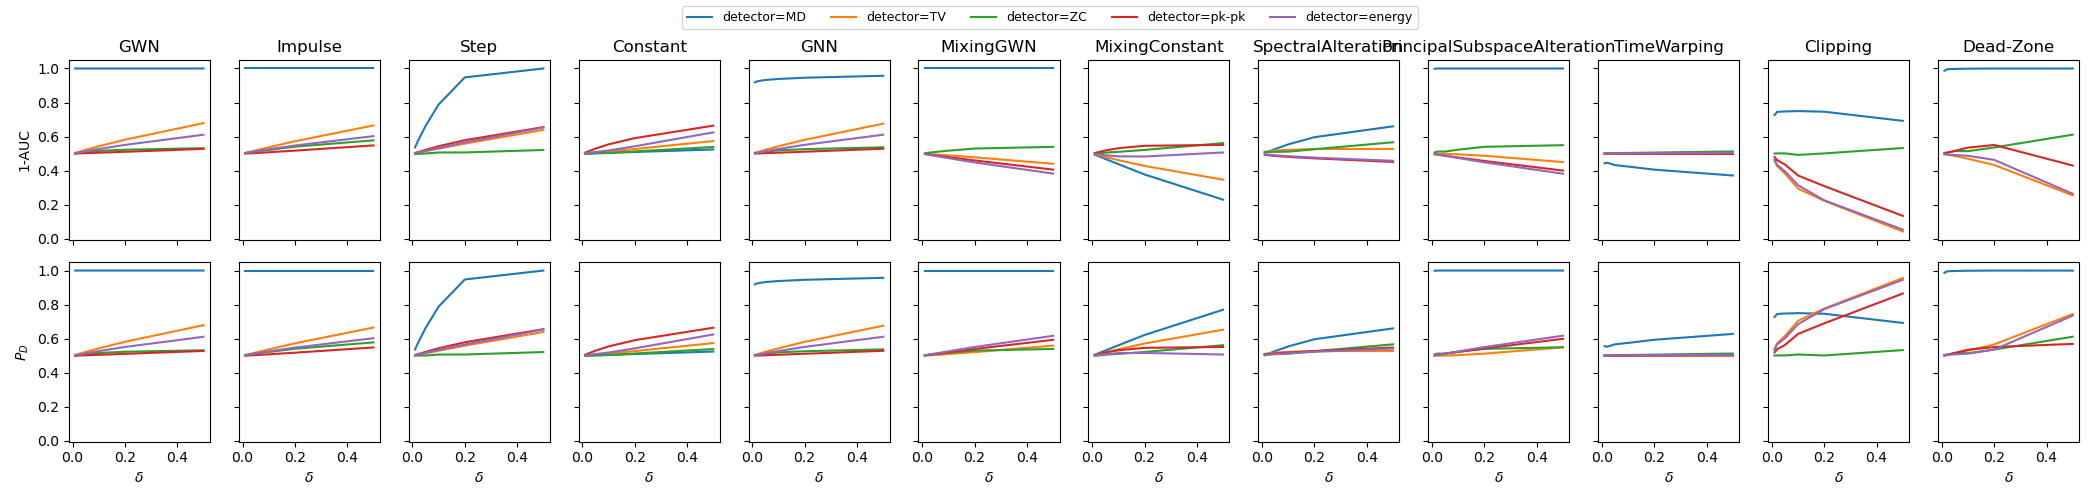

In [37]:
data_FB = results_FB.loc[:, m, mode, orthogonal, seed_mat, :]
plot_performance(data_FB, feature_detectors, 'detector')

## TSOC

In [38]:
def parse_tsoc_parameters(model_name):
    model_name = model_name.split('.pth')[0]
    model_name = model_name.split('TSOC-')[1]
    params = model_name.split('_')
    param_dict = {}
    for param in params:
        key, value = param.split('=')
        # Attempt to convert to int, float, or keep as string
        if value.isdigit():
            param_dict[key] = int(value)
        else:
            try:
                param_dict[key] = float(value)
            except ValueError:
                # Special case for booleans
                if value.lower() in ['true', 'false']:
                    param_dict[key] = value.lower() == 'true'
                else:
                    param_dict[key] = value

    return param_dict

In [39]:
epochs = 1000
trainded_models = os.listdir(os.path.join(models_dir, 'TSOC'))
trainded_models = [trainded_model for trainded_model in trainded_models if f'epochs={epochs}' in trainded_model]

In [40]:
delta_list2 = [0.001, 0.002, 0.005,0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
detector_mode = 'self-assessment'

index = pd.MultiIndex.from_product(
    [delta_list2, m_list, mode_list, ort_list, seed_mat_list, seed_train_list, opt_list, bs_list, min_delta_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', 'seedtrain', 'opt', 'bs', 'mind'])

results_TSOC= pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
for delta in delta_list:
    for trainded_model in trainded_models:
        params = parse_tsoc_parameters(trainded_model)
        # if not params['seedmat'] == 88219:
        #     continue
        trainded_model = f"{trainded_model.split('.pth')[0]}"
        if mode == 'rakeness':
            trainded_model = trainded_model.split('_')[:-2]
            trainded_model = '_'.join(trainded_model)   
        results_subfolder = [file for file in os.listdir(os.path.join(results_folder)) if f'TSOC_{mode}' in file][0]
        results_path = os.path.join(results_folder, results_subfolder, detector_mode,
                                     f'AUC_detector={trainded_model}_delta={delta}_seedko={seed_ko}.pkl')
        if os.path.exists(results_path):
            result = pd.read_pickle(results_path)
            results_TSOC.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params['seedtrain'], params['opt'], params['bs'], params['mind']] = result

In [41]:
(1-results_TSOC).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [81]:
results_TSOC_PD = 0.5 + np.abs(results_TSOC-0.5)
results_TSOC_PD['mean'] = results_TSOC_PD.mean(axis=1)
results_TSOC_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [ ]:
results_TSOC_avg = results_TSOC_PD.groupby('bs').mean()
bs = results_TSOC_avg['mean'].idxmax()
print(f'Best batch size = {bs}')
results_TSOC_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
bs,,,,,,,,,,,,,
32,0.997827,0.998783,0.887562,0.532027,0.977443,0.998242,0.542311,0.982274,0.997210,0.580633,0.886885,0.998272,0.864956
64,0.992464,0.998388,0.883121,0.529542,0.973987,0.995015,0.550277,0.970838,0.993006,0.584245,0.876953,0.998371,0.862184
128,0.998294,0.999846,0.878004,0.517246,0.978291,0.999026,0.556854,0.967385,0.999513,0.586284,0.868205,0.998761,0.862309


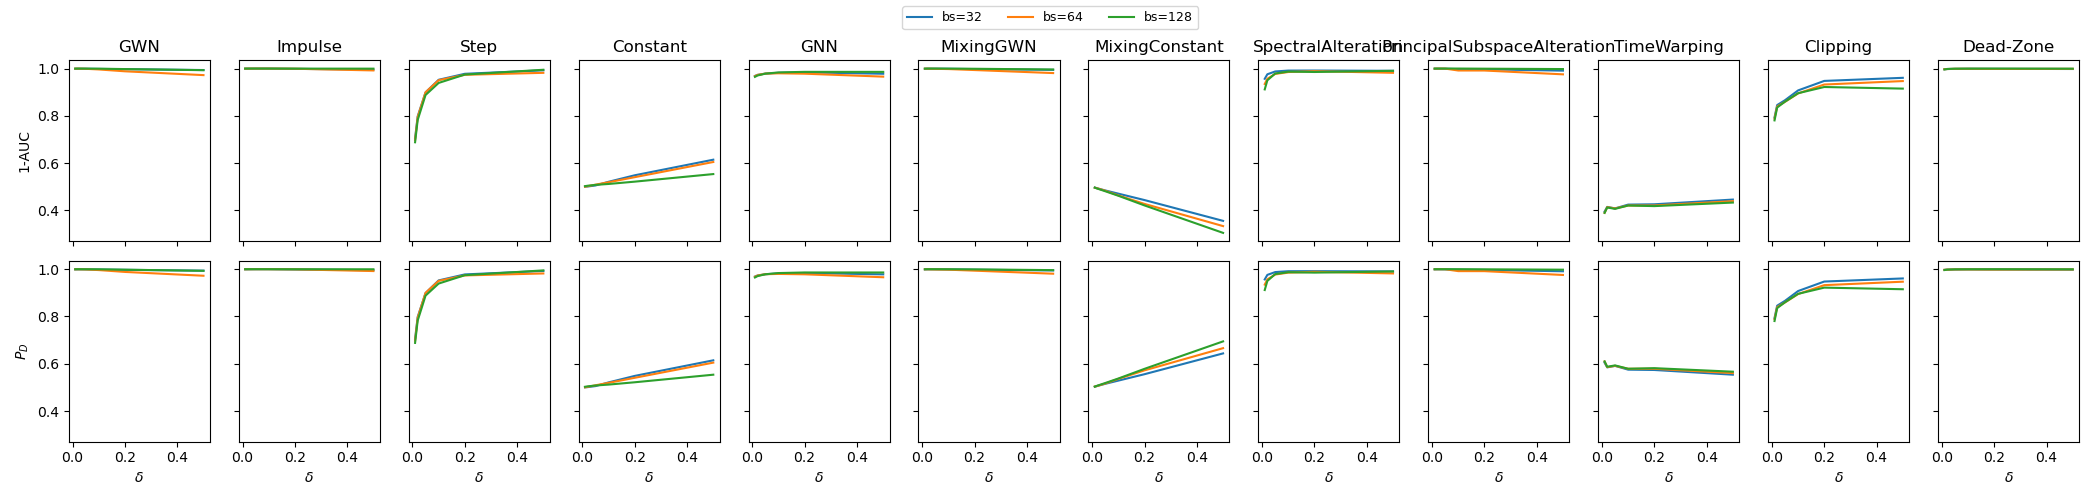

In [43]:
data_TSOC = results_TSOC.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, min_delta]
plot_performance(data_TSOC, bs_list, 'bs')

## Autoencoder

In [44]:
detector_mode = 'autoencoder'
index = pd.MultiIndex.from_product(
    [delta_list, m_list, mode_list, ort_list, seed_mat_list, seed_train_list, opt_list, bs_list, min_delta_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', 'seedtrain', 'opt', 'bs', 'mind'])

results_AE = pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
for delta in delta_list:
    for trainded_model in trainded_models:
        params = parse_tsoc_parameters(trainded_model)
        # if not params['seedmat'] == 88219:
        #     continue
        trainded_model = f"{trainded_model.split('.pth')[0]}"
        if mode == 'rakeness':
            trainded_model = trainded_model.split('_')[:-2]
            trainded_model = '_'.join(trainded_model)   
        results_subfolder = [file for file in os.listdir(os.path.join(results_folder)) if f'TSOC_{mode}' in file][0]
        results_path = os.path.join(results_folder, results_subfolder, detector_mode,
                                     f'AUC_detector={trainded_model}_delta={delta}_seedko={seed_ko}.pkl')
        if os.path.exists(results_path):
            result = pd.read_pickle(results_path)
            results_AE.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params['seedtrain'], params['opt'], params['bs'], params['mind']] = result

In [45]:
(1-results_AE).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [84]:
results_AE_PD = 0.5 + np.abs(results_AE-0.5)
results_AE_PD['mean'] = results_AE_PD.mean(axis=1)
results_AE_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [85]:
results_AE_PD.groupby('bs').mean().style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone,mean
bs,,,,,,,,,,,,,
32,0.999892,0.999901,0.917846,0.532364,0.983292,0.999890,0.582805,0.945082,0.999858,0.617593,0.776302,0.999051,0.862823
64,0.999948,0.999952,0.914495,0.526705,0.982654,0.999947,0.586927,0.922863,0.999921,0.620635,0.768688,0.999068,0.860150
128,1.000000,1.000000,0.913878,0.513106,0.981281,1.000000,0.594894,0.918168,0.999987,0.624171,0.760805,0.999204,0.858791


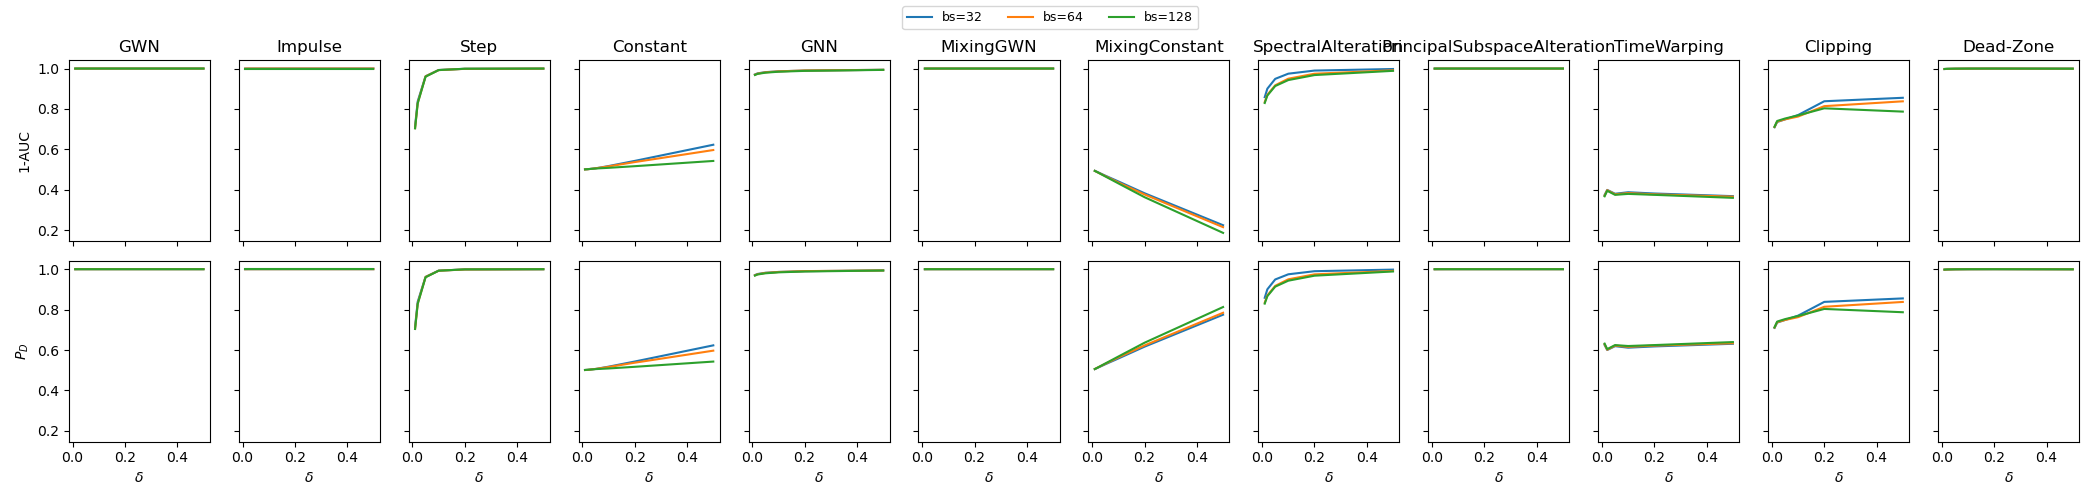

In [47]:
m = 48
mode = 'rakeness'
orthogonal = True
seed_mat = 30808
seed_train = 0
opt = 'adam'
min_delta = 1e-5

data_AE = results_AE.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, min_delta]
plot_performance(data_AE, bs_list, 'bs')

## Comparison

In [ ]:
estimators = 1000
neigbors = 10
nu = 0.01
k_spe =32
k_T2 = 46
order = 24
bs_sa = 32
bs_ae = 32

detector_labels = [f'IF_{estimators}', f'LOF_{neigbors}', f'OCSVM_{nu}', f'SPE_{k_spe}', f'T2_{k_T2}', f'AR_{order}', 'MD', f'SA_{bs_sa}', f'AE_{bs_ae}']

SyntaxError: f-string: single '}' is not allowed (2435241004.py, line 10)